# Problem Set 3, due Wednesday, May 3rd, 5:30pm.

In [2]:
import pandas as pd
from collections import OrderedDict
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf

## Introduction to the assignment

For this assignment, you will be using data from the [Progresa
program](http://en.wikipedia.org/wiki/Oportunidades), a government
social assistance program in Mexico. This program, as well as the
details of its impact, are described in the paper "[School subsidies
for the poor: evaluating the Mexican Progresa poverty
program](http://www.sciencedirect.com/science/article/pii/S0304387803001858)",
by Paul Shultz (available on Canvas).  The data
(progresa_sample.csv.gz) is available on canvas
in files/data.

Please read the paper to familiarize yourself with
the PROGRESA program before beginning this problem set, so you have a
rough sense of where the data come from and how they were
generated. If you just proceed into the problem set without
understanding Progresa or the data, it will be very difficult!

The goal of this problem set is to implement some of the basic
econometric techniques that you are learning in class to measure the
impact of Progresa on secondary school enrollment rates, in particular
differences-in-differences.  Your task is to **estimate the impact of
_progresa_ subsidies on the school attendance**.  Note: this asks to
estimate a causal effect.

The timeline of the program was:

 * Baseline survey conducted in 1997
 * Intervention begins in 1998, "Wave 1" of data collected in 1998
 * "Wave 2 of data" collected in 1999
 * Evaluation ends in 2000, at which point the control villages were treated. 
 
When you are ready, download the progresa_sample.csv data from
Canvas. The data are actual data collected to evaluate the impact of
the Progresa program.  In this file, each row corresponds to an
observation taken for a given child for a given year. There are two
years of data (1997 and 1998), and just under 40,000 children who are
surveyed in both years.  For each child-year observation, the
following variables are collected:

| Variable name | Description|
|------|------|
|year	  |year in which data is collected
|sex	  |male = 1|
|indig	  |indigenous = 1|
|dist_sec |nearest distance to a secondary school|
|sc	      |enrolled in school in year of survey (=1)|
|grc      |grade enrolled|
|fam_n    |family size|
|min_dist |	min distance to an urban center|
|dist_cap |	min distance to the capital|
|poor     |	poor = "pobre", not poor = "no pobre"|
|progresa |treatment = "basal", control = "0"|
|hohedu	  |years of schooling of head of household|
|hohwag	  |monthly wages of head of household|
|welfare_index|	welfare index used to classify poor|
|hohsex	|gender of head of household (male=1)|
|hohage	|age of head of household|
|age	|years old|
|folnum	|individual id|
|village|	village id|
|sc97	|enrolled in school in 1997 (=1) |

## Part 1: Descriptive analysis

### 1.1	Summary Statistics

Report summary statistics (mean, standard deviation, and number of missings) for all of
the demographic variables in the dataset (i.e., everything except
year, folnum, village).  Present the actual levels for 'progresa' and
'poor'.  Do these fit with the documentation above?

Present these in a single table alphabetized
by variable name. Do NOT simply expect the grader to scroll through
your output!

In [4]:
#Read data and segregate according to treatment/control group
data = pd.read_csv("progresa_sample.csv")

#Print the number of null values in each column
missing_values = pd.isnull(data).sum(axis=0)

#Removing variables not needed for missing values
idx1 = pd.Index(['year','folnum','village','poor','progresa'])
index = missing_values.index.difference(idx1)
missing_values = missing_values[index]

In [5]:
#Calculate summary statistics of the data
summary = data.describe()
idx2 = pd.Index(['year','folnum','village'])

#Remove variables not needed in summary statistics
columns = summary.columns.difference(idx2)
summary = summary[columns].T

In [6]:
#Extract mean and standard deviation
mean = summary['mean']
std = summary['std']

In [7]:
#Print the summary statistics
summary_mean_std = pd.concat([mean,std,missing_values],axis=1)

summary_mean_std

,mean,std,0
age,11.366460,3.167744,0
dist_cap,147.674452,76.063134,0
dist_sec,2.418910,2.234109,0
fam_n,7.215715,2.352900,0
grc,3.963537,2.499063,6549
grc97,3.705372,2.572387,0
hohage,44.436717,11.620372,10
hohedu,2.768104,2.656106,0
hohsex,0.925185,0.263095,20
hohwag,586.985312,788.133664,0


In [179]:
data.progresa.unique()

array(['0', 'basal'], dtype=object)

Here, we can see that the progresa variable has two unique values: 0 & basal where basal stands for the treated rows and 0 for the control rows.

### 1.2 Differences at baseline?
Now let's investigate the differences in baseline.  Are the baseline (1997) demographic characteristics **for the poor**
different in treatment and control villages?

I suggest you to use a T-Test to
determine whether there is a statistically significant difference in
the average values of each of the variables in the dataset. Focus only
on the data from 1997 for poor.

Present your results in a single table with the following columns and 14 (or so) rows:

| Variable name | Average value (Treatment villages) | Average value (Control villages) | Difference (Treat - Control) | p-value |
|------|------|------|------|------|
|Male|?|?|?|?|


I choose to drop the null values instead of replacing them with zeros

In [110]:
#Drop null values from data.

#Divide data into treatment and control
treatment_data = data[data.progresa == 'basal']
control_data = data[data.progresa == '0']

#Get treatment and control data from 1997
treatment_data_1997 = treatment_data[treatment_data.year == 97]
control_data_1997 = control_data[control_data.year == 97]

#Slice the data according to poor in treatment villages
treatment_poor = treatment_data[treatment_data.poor == "pobre"]

#Slice the data according to poor in treatment villages
control_poor = control_data[control_data.poor == "pobre"]

#Poor data from 1997
treatment_poor_1997 = treatment_poor[treatment_poor.year == 97]
#Poor data from 1998
treatment_poor_1998 = treatment_poor[treatment_poor.year == 98]

#Poor data from 1997
control_poor_1997 = control_poor[control_poor.year == 97]
#Poor data from 1998
control_poor_1998 = control_poor[control_poor.year == 98]


In [108]:
#Calcaulate mean for the whole data
x = treatment_poor_1997.mean()
y = control_poor_1997.mean()

#Drop unnecessary variables
try:
    x = x.drop('year')
    x = x.drop('folnum')
    x = x.drop('village')
    y = y.drop('year')
    y = y.drop('folnum')
    y = y.drop('village')
    y = y.drop('progresa')
except:
    print('Already dropped')    

In [109]:
#Calculate p-values for all the variable means in treatment and control villages
p_values = []

for i in x.index:    
    t,p = ttest_ind(control_poor_1997[i].values,treatment_poor_1997[i].values)
    p_values.append(p)

#Store p-values in series 
p_values = pd.Series(p_values)

In [59]:
#Convert lists into series
variable_name = pd.Series(x.index)
treatment_values = pd.Series(x.values)
control_values = pd.Series(y.values)

In [60]:
#Create dataframe for the same
baseline_data = pd.DataFrame(OrderedDict({'Variable':variable_name,
                                          'Average value (Treatment villages)':treatment_values,
                                          'Average value (Control villages)':control_values
                                         })
                            )

In [61]:
#Calculate difference between means, p-value and store in dataframe
baseline_data['Difference'] = baseline_data['Average value (Treatment villages)'] - baseline_data['Average value (Control villages)']
baseline_data['p-value'] = p_values

In [62]:
baseline_data

,Variable,Average value (Treatment villages),Average value (Control villages),Difference,p-value
0,sex,0.520268,0.506556,0.013713,1.956962e-02
1,indig,0.316744,0.325306,-0.008562,1.183760e-01
2,dist_sec,2.399648,2.400687,-0.001039,9.670949e-01
3,sc,0.822697,0.815066,0.007631,9.117959e-02
4,grc,3.709214,3.733653,-0.024439,3.947750e-01
5,fam_n,7.281032,7.302939,-0.021907,4.236088e-01
6,min_dist,107.395231,103.098348,4.296884,1.936661e-18
7,dist_cap,151.801472,154.492095,-2.690622,3.414194e-03
8,hohedu,2.726729,2.660982,0.065747,2.613239e-02
9,hohwag,550.207086,580.694452,-30.487366,2.727661e-04


### 1.3 Interpretation

* A: Are there statistically significant differences between treatment and control villages as baseline? 
* B: Why does it matter if there are differences at baseline?
* C: What does this imply about how to measure the impact of the treatment?

* A: Here, first of all we see that there are very few values which are lesser than 0.05, and the most significant ones are hohage, min_dist and welfare_index. However, most of the others are not less than 0.05 which means that the difference in means is not statistically significant
* B: To validate the authenticity of this randomized control trial, we need to make sure that the groups were chosen with completely random methods. If the p-values were significant in most, that means that there is a significant difference at baseline which means that the selection was not random. Hence, we need to make sure that the randomness is intact.
* C: Since, there is no difference in means pre-treatment, we know that treatment was the only thing affecting the enrollment rates and there was no external factor taking part in it.

### 1.4 Graphical exploration, part 1

For each level of household head education, compute the average
enrollment rate in 1997. Create a scatterplot that shows this
relationship. What do you notice?

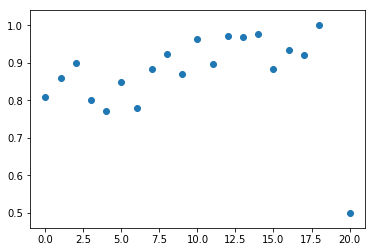

In [84]:
x = data.groupby(['hohedu'])['sc'].mean()
y = x.values
x = data.hohedu.unique()
plt.scatter(x,y)
plt.show()

There is an almost steady increase in average enrollment with an increase in the level of education and it drops suddenly at education level 20.

### 1.5 Graphical exploration, part 2

Create a histogram of village enrollment rates **among poor households
in treated villages**, before and after treatment.  Specifically, for
each village, calculate the average rate of enrollment of poor
households in treated villages in 1997, then compute the average rate
of enrollment of poor households in treated villages in 1998. Create
two separate histograms showing the distribution of these average
enrollments rates, one histogram for 1997 and one histogram for
1998. On each histogram, draw a vertical line that intersects the
x-axis at the average value (across all households). Does there appear
to be a difference? Is this difference statistically significant?

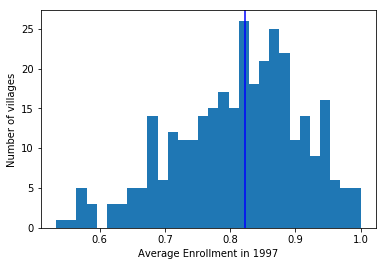

In [71]:
x = treatment_poor_1997.groupby(['village'])['sc97'].mean()
plt.hist(x, bins = 30)
plt.axvline(treatment_poor_1997.sc.mean(), color='blue')
plt.ylabel("Number of villages")
plt.xlabel("Average Enrollment in 1997")
plt.show()

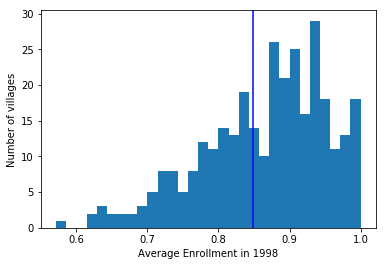

In [70]:
y = treatment_poor_1998.groupby(['village'])['sc97'].mean()
plt.hist(y,bins = 30)
plt.axvline(treatment_poor_1998.sc.mean(), color='blue')
plt.ylabel("Number of villages")
plt.xlabel("Average Enrollment in 1998")
plt.show()

Keeping all values

In [78]:
ttest_ind(treatment_poor_1997.groupby('village')['sc'].mean(),treatment_poor_1998.groupby('village')['sc'].mean()).pvalue

0.010587739721624679

Dropping Null Values

In [80]:
ttest_ind(treatment_poor_1997.groupby('village')['sc'].mean(),treatment_poor_1998.groupby('village')['sc'].mean()).pvalue

0.04424870036572115

Here, we see that the p-value of the means comes out to be 0.0105 if we keep all values for the sc variable pre and post treatment and 0.044 if we drop all the null values. In both the cases, the p-value is less than 0.05 which means that the difference is statistically significant

In [82]:
treatment_poor_1997['sc'].mean()

0.8226968874033842

In [83]:
treatment_poor_1998['sc'].mean()

0.8464791213954308

The above means show that there we can say that there is an improvement in enrollment post treatment and that improvment is statistically significant.

## Part 2: Measuring Impact

Our goal is to estimate the causal impact of the PROGRESA program on
the social and economic outcomes of individuals in Mexico. We will
focus on the impact of the program on the poor (those with
poor=='pobre'), since only the poor were eligible to receive the
PROGRESA assistance.

### 2.1 Cross-Sectional Estimator: T-test

Begin by estimating the impact of Progresa using "simple differences."
Restricting yourself to data from 1998 (after treatment), calculate
the average enrollment rate among **poor** households in the Treatment
villages and the average enrollment rate among **poor** households in
the control villages. Use a t-test to determine if this difference is
statistically significant. What do you conclude?

In [96]:
data_1998 = data[data['year'] == 98].dropna()
poor_1998 = data_1998[data_1998['poor'] == 'pobre'].dropna()

poor_data = data[data['poor'] == 'pobre'].dropna()

In [92]:
print(control_poor_1998.sc.dropna().mean())

0.810923092511906


In [93]:
print(treatment_poor_1998.sc.dropna().mean())

0.849257030578411


In [91]:
ttest_ind(treatment_poor_1998.sc.values,control_poor_1998.sc.values)

Ttest_indResult(statistic=8.101650305300375, pvalue=5.656455605358843e-16)

Here, we see that the p-value is extremely less than 0.05 which shows that the difference is statisitcally significant and that proves that there is an improvement in enrollment post treatment.

### 2.2 Cross-Sectional Estimator: Regression

Estimate the effects of Progresa on enrollment using a regression
model, by regressing the 1998 enrollment rates **of the poor** on
treatment assignment.  Do not include any additional control
variables.
Discuss the following:

* Based on this model, how much did Progresa increase the likelihood of a child enrolling?
* How does your regression estimate compare to your t-test estimate from part 2.1?
* Based on this regression model, can we reject the null hypothesis that the treatment effects are zero? 
* What is the counterfactual assumption underlying this regression?

Note: I recommend to use statsmodels.formula.api as this allows to use
convenient R-style formulas and provedes nice summaries of the results.

In [121]:
model = smf.ols(formula = 'sc ~ progresa',data=poor_1998).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     65.64
Date:                Wed, 02 May 2018   Prob (F-statistic):           5.66e-16
Time:                        14:20:07   Log-Likelihood:                -11171.
No. Observations:               26155   AIC:                         2.235e+04
Df Residuals:                   26153   BIC:                         2.236e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.8109      0.00

* Based on the above results, progresa(treatment) increases the likelihood of a child enrolling by 0.0383
* In 2.1, the t-test estimate was 8.1 whereas the same in the regression, coefficient is 0.0383
* Here, the p-value is less than 0.05. Based on that, we can reject the null hypothesis stating that there is no effect of the treatment.
* We assume that if the treatment was not provided, then the means for both groups will be the same and essentially the groups will be the same.

### 2.3 Multiple Regression

Re-run the above regression estimated but this time include a set of
relevant control variables. Include, for instance, age, distance to a secondary
school, gender, education of household head, welfare index,
indigenous, etc.

* How do the controls affect the point estimate of treatment effect?
* How do the controls affect the standard error on the treatment effect? 
* How do you interpret the differences (or similarities) between your estimates of 2.2 and 2.3?

In [122]:
model = smf.ols(formula = 'sc ~ age + dist_sec + sex + hohedu + indig + min_dist + progresa',data=poor_1998).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     1365.
Date:                Wed, 02 May 2018   Prob (F-statistic):               0.00
Time:                        14:20:11   Log-Likelihood:                -7129.9
No. Observations:               26155   AIC:                         1.428e+04
Df Residuals:                   26147   BIC:                         1.434e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.4630      0.01

* The controls reduce the estimate point of treatment effects from 0.0383 to 0.0319
* The standard error reduced from 0.005 to 0.004
* As the controls added try to explain the outcome variable, we see the reduction in point estimate of the progresa variable, but still it is minute hence the other variables are not able to explain the outcome very significantly.

### 2.4 Difference-in-Difference, version 1 (tabular)

Thus far, we have computed the effects of Progresa by estimating the
difference in 1998 enrollment rates across villages. An alternative
approach would be to compute the treatment effect using a
difference-in-differences framework.

Begin by estimating the average treatment effects of the program for poor households using data from 1997 and 1998. Specifically, calculate:

a) the difference (between 1997 and 1998) in enrollment rates among poor households in treated villages

b) the difference (between 1997 and 1998) in enrollment rates among poor households in control villages.

c) The difference between these two differences is your estimate.

* What is your estimate of the impact, and how does it compare to your earlier (simple difference) results?

* What is the counterfactual assumption underlying this estimate? 


In [111]:
#Difference in treatment
difference_treated_poor = treatment_poor_1998.sc.mean() - treatment_poor_1997.sc.mean() 

#Difference in control
difference_control_poor = control_poor_1998.sc.mean() - control_poor_1997.sc.mean()

#Difference in difference
difference_in_difference = difference_treated_poor - difference_control_poor

print(difference_in_difference)

0.031331280319323085



* The difference in difference value comes out to be 0.0313 which is slightly similar to the controls estimate of 0.0319 but much lower than than the simple estimate 0.0383

* The counterfactual assumption here is that the difference in the comparison groups represents the counterfactual change in the treatment group if there were no treatment.

### 2.5 Difference-in-Difference, version 2 (regression)

Now use a regression specification to estimate the average treatment
effects of the program in a difference-in-differences
framework. Include at least 5 control variables.

* What is your estimate of the impact of Progresa? Be very specific in
  interpreting your coefficients and standard errors, and make sure to
  specify exactly what units you are measuring and estimating.

* How do these estimates of the treatment effect compare to the
  estimates based on the simple difference?

* How do these estimates compare to the difference-in-difference
  estimates from 2.4 above? What accounts for these differences?

* What is the counterfactual assumption underlying this regression? 

In [123]:
#Define variable for pre and post treatment
def  categorize(year):
    if year == 97:
        return 0 
    else:
        return 1

poor_data['post'] = [categorize(x) for x in poor_data['year']]

In [119]:
model = smf.ols(formula="sc ~ progresa + post + progresa:post + age + dist_sec + sex + hohedu + min_dist ", data=poor_data, missing='drop').fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     2756.
Date:                Wed, 02 May 2018   Prob (F-statistic):               0.00
Time:                        14:19:50   Log-Likelihood:                -16139.
No. Observations:               56893   AIC:                         3.230e+04
Df Residuals:                   56884   BIC:                         3.238e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1.4331      0.007    198.380      0.000       1.419       1.447
progresa[T.basal]          0.0009      0.004      0.245      0.806      -0.006       0.008
post                       0.0323      0.004      7.334      0.000       0.024       0.041
progresa[T.basal]:post     0.0305      0.006      5.466      0.000       0.020       0.041
age                       -0.0653      0.000   -142.654      0.000      -0.066      -0.064
dist_sec                  -0.0094      0.001    -14.825      0.000      -0.011      -0.008
sex                        0.0332      0.003     12.303      0.000       0.028       0.038
hohedu                     0.0071      0.001     13.116      0.000       0.006       0.008
min_dist                   0.0007   3.23e-05     21.943      0.000       0.001       0.001
==============================================================================
Omnibus:                     5494.032   Durbin-Watson:                   1.486
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7259.719
Skew:                          -0.873   Prob(JB):                         0.00
Kurtosis:                       3.127   Cond. No.                         693.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* Estimate of impact with the controls and interaction terms comes out to 0.0305 with a p-value less than 0.05 which shows that it is significant. Also, if we look at progresa without interaction, the estimate is 0.0009 and it is not significant as well. Also, since the standard error is also low, we can say that the treatment increased the likelihood of enrollment average by 0.0305.

* In the simple estimates, we only considered after progresa data. We didnt look at difference before that. In this estimate, we ssee the difference in treatment and control before and after progresa as well. 

* There is a little decrease in the estimate to 0.0305 from 0.0313. This might be due to the other variables explaining a little effect in the regression.

* The assumption here is that the difference-in-difference between treatment and control groups would be zero if the treatment were absent.

### 2.6 Summary

* Based on all the analysis you have undertaken to date, do you
  believe that Progresa had a causal impact on the enrollment rates of
  poor households in Mexico?  Explain by referring to the methods and
  results above.

From all of the above results, difference-in-difference tabular and regression, simple estimates and also controls in regression, we can say that progresa did have an effect albeit a small one on the enrollemnt rates of poor households in Mexico. Though it is not significant, because we carried out a lot of different analyses and all of them proved that there was a difference, we can say that Progresa had an impact on the enrollment rates. But we should ensure that the treatment is received only by the ones who need it.